### 2. mnist 데이터세트로 딥러닝 분류

Using device: cuda
SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
)

학습 시작...
Epoch 1: Train Loss: 0.1311, Train Acc: 95.89% | Test Loss: 0.0517, Test Acc: 98.45%
Epoch 2: Train Loss: 0.0414, Train Acc: 98.74% | Test Loss: 0.0311, Test Acc: 99.04%
Epoch 3: Train Loss: 0.0287, Train Acc: 99.08% | Test Loss: 0.0320, Test Acc: 98.94%
Epoch 4: Train Loss: 0.0211, Train Acc: 99.33% | Test Loss: 0.0340, Test Acc: 98.93%
Epoch 5: Train Loss: 0.0160, Train Acc: 99.47% | Test Loss: 0.0291, Test Acc: 99.15%
Epoch 6: Train Loss: 0.0133, Train Acc: 99.57% | Test Loss: 0.0353, Test Acc: 98.93%
Epoch 7: Train Loss: 0.0105, Train Acc: 99.62% | Test Loss: 0.0331, T

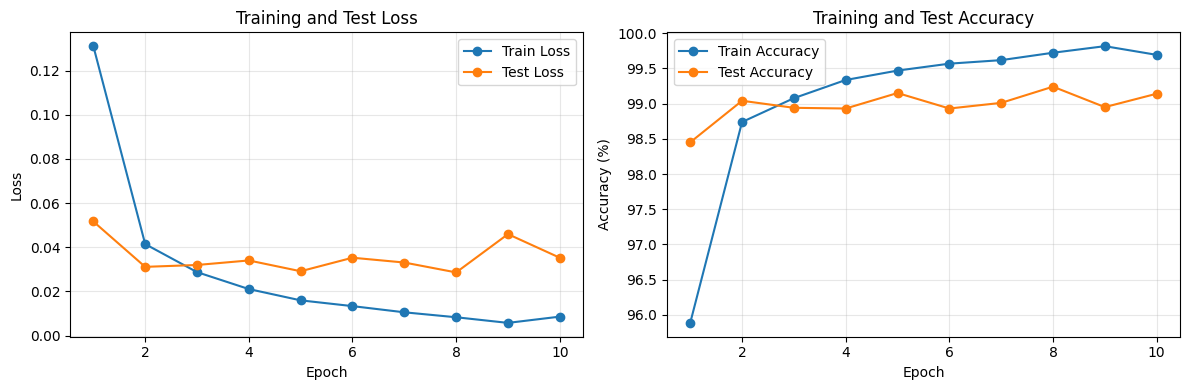


최종 Test Accuracy: 99.14%


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# 디바이스 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# 데이터 로드
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# 간단한 CNN 모델
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))  # 28x28 -> 14x14
        x = self.pool(self.relu(self.conv2(x)))  # 14x14 -> 7x7
        x = x.view(-1, 64 * 7 * 7)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(model)

# 학습 함수
def train(epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)

    avg_loss = train_loss / len(train_loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

# 테스트 함수
def test():
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)

    avg_loss = test_loss / len(test_loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

# 학습 실행
epochs = 10
train_losses, train_accs = [], []
test_losses, test_accs = [], []

print("\n학습 시작...")
for epoch in range(1, epochs + 1):
    train_loss, train_acc = train(epoch)
    test_loss, test_acc = test()

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)

    print(f'Epoch {epoch}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')

# 그래프 그리기
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss 그래프
axes[0].plot(range(1, epochs+1), train_losses, label='Train Loss', marker='o')
axes[0].plot(range(1, epochs+1), test_losses, label='Test Loss', marker='o')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Test Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy 그래프
axes[1].plot(range(1, epochs+1), train_accs, label='Train Accuracy', marker='o')
axes[1].plot(range(1, epochs+1), test_accs, label='Test Accuracy', marker='o')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training and Test Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('cnn_mnist_results.png', dpi=100, bbox_inches='tight')
plt.show()

print(f'\n최종 Test Accuracy: {test_accs[-1]:.2f}%')